# Preprocessing

In [1]:
import pandas as pd
import seaborn as sns

### Distribuzione dei dati

In [2]:
#carico il dataframe pickle in df
df= pd.read_pickle("../data/full_rows_df.pkl")  
df.head()


,VoltageCurve,CurrentCurve,spotName,TimeStamp
0,None,None,60090_0_00,2019-11-07 12:29:01
1,None,None,60092_0_00,2019-11-07 12:29:01
2,None,None,60094_0_00,2019-11-07 12:29:01
3,None,None,60096_0_00,2019-11-07 12:29:01
4,None,None,60118_0_00,2019-11-07 12:29:01


In [3]:
len(df)

222866

In [4]:
#distribuzione dati per mese e anno
df["TimeStamp"].groupby([df['TimeStamp'].dt.year.rename('anno'), df['TimeStamp'].dt.month.rename('mese')]).count()

anno  mese
2019  9        4906
      11      28116
      12      47733
2020  1       56552
      2       50975
      3       31296
      5        3288
Name: TimeStamp, dtype: int64

In [5]:
#distribuzioni percentuali per mese e anno
df["TimeStamp"].groupby([df['TimeStamp'].dt.year.rename('anno'), df['TimeStamp'].dt.month.rename('mese')]).count()/len(df)*100

anno  mese
2019  9        2.201323
      11      12.615652
      12      21.417803
2020  1       25.374889
      2       22.872488
      3       14.042519
      5        1.475326
Name: TimeStamp, dtype: float64

<AxesSubplot:xlabel='TimeStamp', ylabel='Percent'>

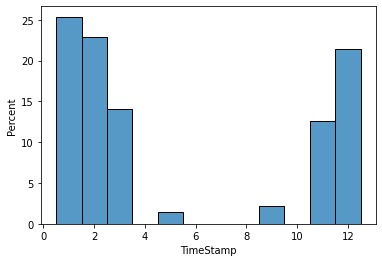

In [6]:
#istogramma numerosità dati per mese, in percentuale
sns.histplot(df.TimeStamp.dt.month,stat="percent",discrete=True)

In [7]:
#distribuzione dati di 09-2019
df["TimeStamp"][df.TimeStamp.dt.month==9].groupby(df.TimeStamp.dt.day).count()

TimeStamp
17     595
18    1445
19    1968
23     276
25     101
26     521
Name: TimeStamp, dtype: int64

In [8]:
#distribuzione dati di 05-2020
df["TimeStamp"][df.TimeStamp.dt.month==5].groupby(df.TimeStamp.dt.day).count()

TimeStamp
4      458
5     1144
6      767
27     306
28     613
Name: TimeStamp, dtype: int64

### Missing values e anomali

In [9]:
#missing values di spotName, valori assoluti e pecentuali
df[df['spotName']==''].count(),df[df['spotName']==''].count()/df["TimeStamp"].count()
#ci sono 727 records senza spotName e di questi 27 non hanno valori di current e voltage
#rappresentano solo lo 0,3% dei dati

(VoltageCurve    700
 CurrentCurve    700
 spotName        727
 TimeStamp       727
 dtype: int64,
 VoltageCurve    0.003141
 CurrentCurve    0.003141
 spotName        0.003262
 TimeStamp       0.003262
 dtype: float64)

In [10]:
#verifico quanti valori effettivi e percentuale di voltage e current sono presenti in df
df[["VoltageCurve","CurrentCurve"]].count(),df[["VoltageCurve","CurrentCurve"]].count()/df["TimeStamp"].count()*100
# abbiamo 177.872 valori su 222.866 ovvero il 79,81% dei dati

(VoltageCurve    177872
 CurrentCurve    177872
 dtype: int64,
 VoltageCurve    79.811187
 CurrentCurve    79.811187
 dtype: float64)

In [11]:
#percentuale dati mancanti in base all'anno
df.groupby(df.TimeStamp.dt.year).count().divide(df["spotName"].groupby(df.TimeStamp.dt.year).count(),axis=0)

,VoltageCurve,CurrentCurve,spotName,TimeStamp
TimeStamp,,,,
2019,0.778726,0.778726,1.0,1.0
2020,0.809128,0.809128,1.0,1.0


In [12]:
#percentuale dati mancanti in base all mese
df.groupby(df.TimeStamp.dt.month).count().divide(df["spotName"].groupby(df.TimeStamp.dt.month).count(),axis=0)

,VoltageCurve,CurrentCurve,spotName,TimeStamp
TimeStamp,,,,
1,0.852507,0.852507,1.0,1.0
2,0.753624,0.753624,1.0,1.0
3,0.825505,0.825505,1.0,1.0
5,0.767640,0.767640,1.0,1.0
9,1.000000,1.000000,1.0,1.0
11,0.682067,0.682067,1.0,1.0
12,0.812918,0.812918,1.0,1.0


#### Gestione dei valori -1 o 0 di VoltageCurve o CurrentCurve come Error

In [13]:
#creo una colonna Error per cui avrò True quanto i valori di Voltage o Current sono pari a -1
df['Error'] = df['CurrentCurve'].apply(lambda x: True if x==[-1] else False)

In [14]:
df["Error2"] = df['CurrentCurve'].apply(lambda x: True if x==[0] else False)
print(len((df[df["Error"]==True])))

35148


In [15]:
# numerosità degli errori
print(len((df[df["Error"]==True])))
#percentuale dati con errore sul totale
round(len((df[df["Error"]==True]))/len(df),4)*100

35148


15.770000000000001

In [16]:
#percentuale di -1 per mese e anno
df["Error"][df["Error"]==True].groupby([df[df["Error"]==True].TimeStamp.dt.year.rename("anno"),df[df["Error"]==True].TimeStamp.dt.month.rename("mese")]).count()/len(df[df["Error"]==True])

anno  mese
2019  11      0.151758
      12      0.237738
2020  1       0.238107
      2       0.215830
      3       0.144048
      5       0.012518
Name: Error, dtype: float64

I dati mancanti e di Error sembrano essere distribuiti tra i diversi anni e mesi di raccolta, a parte settembre 2019 i cui non sono presenti Error o valori mancanti (in questo mese abbiamo comunque una raccolta esigua)

In [17]:
#rimozione istanze con VoltageCurve o CurrentCurve mancanti
df_processed=df[df['VoltageCurve'].notna()]
len(df_processed)

177872

In [18]:
df_processed=df_processed[df_processed["Error"]==False]
df_processed=df_processed[df_processed["Error2"]==False]
len(df_processed)

142203

In [19]:
#rimangono ancora i casi in cui lo spotName non è definito!
df_processed["TimeStamp"][df_processed['spotName']==''].count()

532

In [20]:
#poichè sono solo 532 dati su 142.203 decidiamo di rimuovere anche queste istanze dalle nostre analisi
df_processed=df_processed[df_processed['spotName']!='']
len(df_processed)

141671

In [23]:
#rimozione colonna Error, non più utile
df_processed.drop(["Error","Error2"],axis=1,inplace=True)

In [24]:
#salvo df_processed in formato pickle
df_processed.to_pickle("../data/clean_rows_df.pkl")